In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime
from sklearn.linear_model import LinearRegression

from matplotlib.colors import LogNorm


plt.rcParams['font.family'] = ['sans-serif']
#plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'svg' 

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')  

# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### **Linear Model**

$$
\boldsymbol{y} = \boldsymbol{X}\boldsymbol{w} + b + \epsilon
$$

 

#### **SGD, Adagrad, RMSprop, Momentum, Adam**

In [2]:

class GD():
    def __init__(self, eta=1e-3):
        self.eta = eta

    def Delta(self, dg):
        return -self.eta * dg


class Adagrad():
    def __init__(self, eta=1e-3, epsilon=1e-8):
        self.eta = eta
        self.epsilon = epsilon
        self.past_g = 0

    def Delta(self, dg):
        self.past_g += dg**2
        inv_G = np.diag((self.past_g**(1/2)+self.epsilon)**(-1))
        return -self.eta * inv_G @ dg

class RMSprop():
    def __init__(self, eta=1e-3, gamma = 0.9, epsilon=1e-8):
        self.eta = eta
        self.gamma = gamma
        self.epsilon = epsilon
        self.v = 0

    def Delta(self, dg):
        self.v = self.gamma * self.v + (1-self.gamma)*dg*dg
        inv_V = np.diag((self.v**(1/2)+self.epsilon)**(-1))
        return -self.eta * inv_V @ dg


class Momentum():
    def __init__(self, eta=1e-3, gamma = 0.9):
        self.eta = eta
        self.gamma = gamma
        self.m = 0

    def Delta(self, dg):
        self.m = self.gamma*self.m - (1-self.gamma)*dg
        return self.eta * self.m

class Adam():
    def __init__(self, eta=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.m, self.v = 0,0
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.eta = eta
        self.t = 0

    def Delta(self, dg):
        self.t += 1
        self.m = self.beta1*self.m - (1-self.beta1)*dg
        self.v = self.beta2*self.v + (1-self.beta2)*dg**2
        hat_m = self.m/(1-self.beta1**self.t)
        hat_v = self.v/(1-self.beta2**self.t)
        inv_hat_V = np.diag((hat_v**(1/2) + self.epsilon)**(-1))
        return self.eta * inv_hat_V @ hat_m

In [3]:
def Gradient(X, y, theta):
    return -X.T @ (y - X @ theta) / len(y)

def LS_obj(X, y, theta):
    res = y - X @ theta
    return res.T @ res / len(y)

def gradient_descent(X, y, optimizer, epochs=1e5):
    intercept = np.ones(len(X)).reshape(-1,1)
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
        X, y = np.hstack((intercept, X)), np.array(y)
        theta_t = np.zeros(np.shape(X)[1])
        for epoch in range(int(epochs)):
            # calculate gradient
            dg = Gradient(X, y, theta_t)
            theta_t += optimizer.Delta(dg) # update direction is given by the choice of optimizer
            fit = LS_obj(X, y, theta_t)
        return({"Optimizer": optimizer.__class__.__name__, "omega": np.squeeze(theta_t[1:]), "b": theta_t[0], "obj": fit})

#### **Run these algorithms on real datasets**

In [ ]:
data = pd.read_csv("./data/Advertising.csv", index_col=0)
X, y = data["TV"].values , data["sales"].values


print(gradient_descent(X, y, GD(eta=1e-5), epochs=1e6))
print(gradient_descent(X, y, Adagrad(eta=1), epochs=1e4))
print(gradient_descent(X, y, RMSprop(eta=1e-4), epochs=1e5))
print(gradient_descent(X, y, Momentum(eta=1e-4), epochs=2e5))
print(gradient_descent(X, y, Adam(eta=1), epochs=1e3))

### **Beale Function**


$$ f(x,y) = (1.5-x + x \cdot y)^2 + (2.25 - x + x\cdot y^2 ) ^2 + (2.625 - x + x\cdot y^3 )^2$$

Search domain: $x, y \in [-4.5, 4.5]$

Global minimizer: $ (x^*, y^*) = (3.5, 0.5)$

Global minimum: $f(x^*, y^*) = 0$ 

In [5]:
Beale = lambda x, y: (1.5-x+x*y)**2 + (2.25-x+x*y**2)**2 + (2.625-x+x*y**3)**2

xmin, xmax, xstep = -4.5, 4.5, .2
ymin, ymax, ystep = -4.5, 4.5, .2

x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))

z = Beale(x, y)

#### Mesh plot

array([[3. ],
       [0.5]])

Text(0.5, 0, '$x$')

Text(0.5, 0.5, '$y$')

Text(0.5, 0, '$z$')

(-4.5, 4.5)

(-4.5, 4.5)

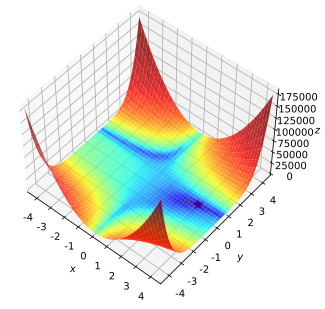

In [6]:
minima = np.array([3., .5])
minima_ = minima.reshape(-1, 1)
minima_

fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima_, Beale(*minima_), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

#### Run these algorithms

In [7]:
def Beale_Gradient(theta):
    x, y = theta
    dx = -12.75 + 3*y + 4.5*y**2 + 5.25*y**3 + 2*x*(3-2*y-y**2-2*y**3+y**4+y**6)
    dy = 6*x*(0.5+1.5*y+2.625*y**2+x*(-1/3-1/3*y-y**2+2/3*y**3+y**5))
    return np.array([dx, dy])

def Beale_Gradient_Descent(theta_t, optimizer, max_epochs=1e5, tol=1e-5):
    paths = [theta_t]
    for _ in range(int(max_epochs)):
        dg = Beale_Gradient(theta_t)
        theta_new = theta_t+optimizer.Delta(dg)
        paths.append(theta_new)
        if sum((theta_new-theta_t)**2) < tol**2: # terminate if the parameter change is small enough
            return (np.squeeze(paths))
        theta_t = theta_new
    return (np.squeeze(paths))

start = np.array([1,1])
start_ = start.reshape(-1,1)

GD_path = Beale_Gradient_Descent(start, GD(eta=1e-2))
Adagrad_path = Beale_Gradient_Descent(start, Adagrad(eta=1))
RMSprop_path = Beale_Gradient_Descent(start, RMSprop(eta=1e-3))
Momentum_path = Beale_Gradient_Descent(start, Momentum(eta=1e-1))
Adam_path = Beale_Gradient_Descent(start, Adam(eta=1))

print({'GD': len(GD_path), 'GD_solution':GD_path[-1]})
print({'Adagrad': len(Adagrad_path), 'Adgrad_solution': Adagrad_path[-1]})
print({'RMSprop': len(RMSprop_path), 'RMSprop_solution': RMSprop_path[-1]})
print({'Momentum': len(Momentum_path), 'Momentum_soltuion': Momentum_path[-1]})
print({'Adam': len(Adam_path), 'Adam_solution': Adam_path[-1]})

print({"nstep": len(RMSprop_path), "eta": 1e-3, "RMSprop": RMSprop_path[-1]})

{'GD': 1562, 'GD_solution': array([2.99681073, 0.49920285])}
{'Adagrad': 198, 'Adgrad_solution': array([2.99975043, 0.49993668])}
{'RMSprop': 100001, 'RMSprop_solution': array([3.00047138, 0.49949234])}
{'Momentum': 196, 'Momentum_soltuion': array([3.0001924, 0.5000164])}
{'Adam': 210, 'Adam_solution': array([2.99992623, 0.49998811])}
{'nstep': 100001, 'eta': 0.001, 'RMSprop': array([3.00047138, 0.49949234])}


#### Stepsize matters in the algorithms

Let's tune the stepsize of RMSprop

In [8]:
RMSprop_path = Beale_Gradient_Descent(start, RMSprop(eta=1e-5))
print({"nstep": len(RMSprop_path), "eta": 1e-5, "RMSprop": RMSprop_path[-1]})

RMSprop_path = Beale_Gradient_Descent(start, RMSprop(eta=1e-4))
print({"nstep": len(RMSprop_path), "eta": 1e-4, "RMSprop": RMSprop_path[-1]})

RMSprop_path = Beale_Gradient_Descent(start, RMSprop(eta=1e-3))
print({"nstep": len(RMSprop_path), "eta": 1e-3, "RMSprop": RMSprop_path[-1]})

RMSprop_path = Beale_Gradient_Descent(start, RMSprop(eta=1e-2))
print({"nstep": len(RMSprop_path), "eta": 1e-2, "RMSprop": RMSprop_path[-1]})

RMSprop_path = Beale_Gradient_Descent(start, RMSprop(eta=1e-1))
print({"nstep": len(RMSprop_path), "eta": 1e-1, "RMSprop": RMSprop_path[-1]})

RMSprop_path = Beale_Gradient_Descent(start, RMSprop(eta=1))
print({"nstep": len(RMSprop_path), "eta": 1, "RMSprop": RMSprop_path[-1]})

{'nstep': 87458, 'eta': 1e-05, 'RMSprop': array([1.87523275, 0.12632781])}
{'nstep': 100001, 'eta': 0.0001, 'RMSprop': array([2.99994971, 0.50004992])}
{'nstep': 100001, 'eta': 0.001, 'RMSprop': array([3.00047138, 0.49949234])}
{'nstep': 100001, 'eta': 0.01, 'RMSprop': array([2.99215914, 0.50423789])}
{'nstep': 100001, 'eta': 0.1, 'RMSprop': array([2.77375513, 0.49763707])}
{'nstep': 100001, 'eta': 1, 'RMSprop': array([0.33737473, 0.8364343 ])}


### Let's plot these algorithms with different stepsizes

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Gradient Descent')

<a list of 27 text.Text objects>

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Gradient Descent')

<a list of 27 text.Text objects>

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Gradient Descent')

<a list of 27 text.Text objects>

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Gradient Descent')

<a list of 27 text.Text objects>

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Gradient Descent')

<a list of 27 text.Text objects>

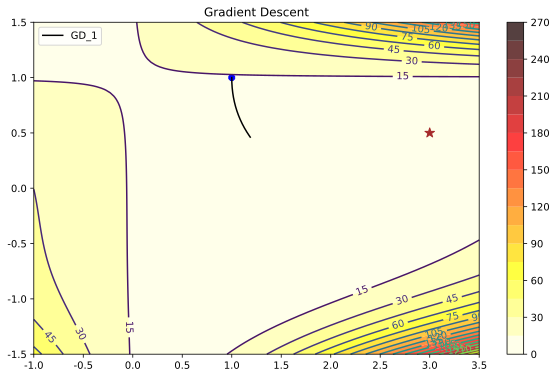

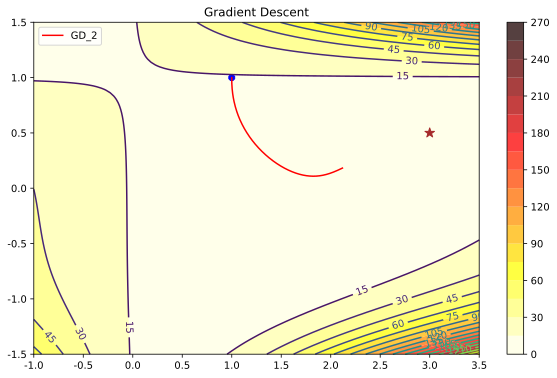

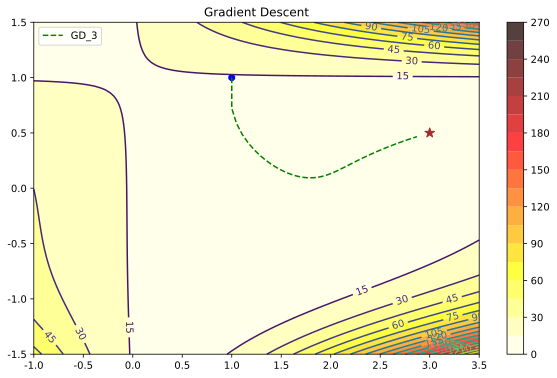

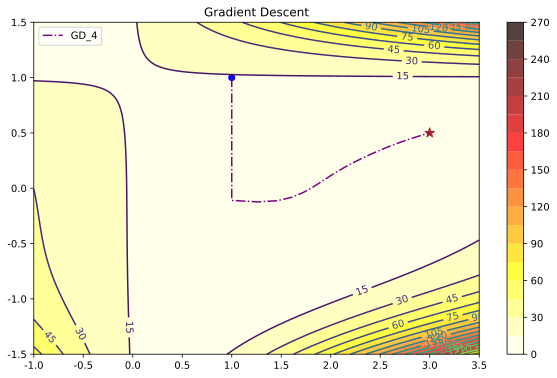

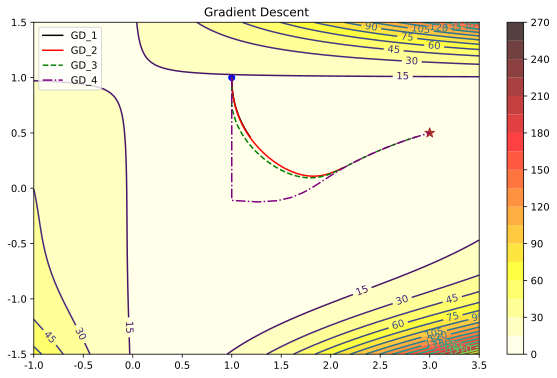

In [9]:
from IPython.core.interactiveshell import InteractiveShell


InteractiveShell.ast_node_interactivity = "last"
plt.figure(figsize=(10,6))

plt.title('Gradient Descent')
x1_con = np.linspace(-1,3.5,100)
x2_con = np.linspace(-1.5,1.5,100)
x1_mes, x2_mes = np.meshgrid(x1_con,x2_con)
y_con = Beale(x1_mes,x2_mes)
# plt.plot(x1_mes, x2_mes)
cset = plt.contourf(x1_mes,x2_mes,y_con, levels=20, alpha=.75, cmap='hot_r')
plt.colorbar(cset)
C = plt.contour(x1_mes,x2_mes,y_con, levels=20, camp='RdYlBu')  
plt.clabel(C, inline=True, fontsize=10)
plt.scatter(1, 1, marker="8", color="b", s=40)
plt.scatter(3, 0.5, marker="*", color="brown", s=100)


GD_path_1 = Beale_Gradient_Descent(start, GD(eta=1e-4))
x_path, y_path = GD_path_1[:,0][0:400], GD_path_1[:,1][0:400]
plt.plot(x_path, y_path, label='GD_1',color='black')

# GD_path_2 = Beale_Gradient_Descent(start, GD(eta=1e-3))
# x_path, y_path = GD_path_2[:,0][0:400], GD_path_2[:,1][0:400]
# plt.plot(x_path, y_path, label='GD_2', linestyle='-')

# GD_path_3 = Beale_Gradient_Descent(start, GD(eta=1e-2))
# x_path, y_path = GD_path_3[:,0][0:400], GD_path_3[:,1][0:400]
# plt.plot(x_path, y_path, label='GD_3', linestyle='--')

# GD_path_4 = Beale_Gradient_Descent(start, GD(eta=4e-2))
# x_path, y_path = GD_path_4[:,0][0:400], GD_path_4[:,1][0:400]
# plt.plot(x_path, y_path, label='GD_4', linestyle='-.')

plt.legend(loc='upper left')



InteractiveShell.ast_node_interactivity = "last"
plt.figure(figsize=(10,6))

plt.title('Gradient Descent')
x1_con = np.linspace(-1,3.5,100)
x2_con = np.linspace(-1.5,1.5,100)
x1_mes, x2_mes = np.meshgrid(x1_con,x2_con)
y_con = Beale(x1_mes,x2_mes)
# plt.plot(x1_mes, x2_mes)
cset = plt.contourf(x1_mes,x2_mes,y_con, levels=20, alpha=.75, cmap='hot_r')
plt.colorbar(cset)
C = plt.contour(x1_mes,x2_mes,y_con, levels=20, camp='RdYlBu')  
plt.clabel(C, inline=True, fontsize=10)
plt.scatter(1, 1, marker="8", color="b", s=40)
plt.scatter(3, 0.5, marker="*", color="brown", s=100)


# GD_path_1 = Beale_Gradient_Descent(start, GD(eta=1e-4))
# x_path, y_path = GD_path_1[:,0][0:400], GD_path_1[:,1][0:400]
# plt.plot(x_path, y_path, label='GD_1')

GD_path_2 = Beale_Gradient_Descent(start, GD(eta=1e-3))
x_path, y_path = GD_path_2[:,0][0:400], GD_path_2[:,1][0:400]
plt.plot(x_path, y_path, label='GD_2', linestyle='-',   color='red')

# GD_path_3 = Beale_Gradient_Descent(start, GD(eta=1e-2))
# x_path, y_path = GD_path_3[:,0][0:400], GD_path_3[:,1][0:400]
# plt.plot(x_path, y_path, label='GD_3', linestyle='--', color='green')

# GD_path_4 = Beale_Gradient_Descent(start, GD(eta=4e-2))
# x_path, y_path = GD_path_4[:,0][0:400], GD_path_4[:,1][0:400]
# plt.plot(x_path, y_path, label='GD_4', linestyle='-.',  color='purple')

plt.legend(loc='upper left')





InteractiveShell.ast_node_interactivity = "last"
plt.figure(figsize=(10,6))

plt.title('Gradient Descent')
x1_con = np.linspace(-1,3.5,100)
x2_con = np.linspace(-1.5,1.5,100)
x1_mes, x2_mes = np.meshgrid(x1_con,x2_con)
y_con = Beale(x1_mes,x2_mes)
# plt.plot(x1_mes, x2_mes)
cset = plt.contourf(x1_mes,x2_mes,y_con, levels=20, alpha=.75, cmap='hot_r')
plt.colorbar(cset)
C = plt.contour(x1_mes,x2_mes,y_con, levels=20, camp='RdYlBu')  
plt.clabel(C, inline=True, fontsize=10)
plt.scatter(1, 1, marker="8", color="b", s=40)
plt.scatter(3, 0.5, marker="*", color="brown", s=100)


# GD_path_1 = Beale_Gradient_Descent(start, GD(eta=1e-4))
# x_path, y_path = GD_path_1[:,0][0:400], GD_path_1[:,1][0:400]
# plt.plot(x_path, y_path, label='GD_1')

# GD_path_2 = Beale_Gradient_Descent(start, GD(eta=1e-3))
# x_path, y_path = GD_path_2[:,0][0:400], GD_path_2[:,1][0:400]
# plt.plot(x_path, y_path, label='GD_2', linestyle='-',   color='red')

GD_path_3 = Beale_Gradient_Descent(start, GD(eta=1e-2))
x_path, y_path = GD_path_3[:,0][0:400], GD_path_3[:,1][0:400]
plt.plot(x_path, y_path, label='GD_3', linestyle='--', color='green')

# GD_path_4 = Beale_Gradient_Descent(start, GD(eta=4e-2))
# x_path, y_path = GD_path_4[:,0][0:400], GD_path_4[:,1][0:400]
# plt.plot(x_path, y_path, label='GD_4', linestyle='-.',  color='purple')

plt.legend(loc='upper left')



InteractiveShell.ast_node_interactivity = "last"
plt.figure(figsize=(10,6))

plt.title('Gradient Descent')
x1_con = np.linspace(-1,3.5,100)
x2_con = np.linspace(-1.5,1.5,100)
x1_mes, x2_mes = np.meshgrid(x1_con,x2_con)
y_con = Beale(x1_mes,x2_mes)
# plt.plot(x1_mes, x2_mes)
cset = plt.contourf(x1_mes,x2_mes,y_con, levels=20, alpha=.75, cmap='hot_r')
plt.colorbar(cset)
C = plt.contour(x1_mes,x2_mes,y_con, levels=20, camp='RdYlBu')  
plt.clabel(C, inline=True, fontsize=10)
plt.scatter(1, 1, marker="8", color="b", s=40)
plt.scatter(3, 0.5, marker="*", color="brown", s=100)


# GD_path_1 = Beale_Gradient_Descent(start, GD(eta=1e-4))
# x_path, y_path = GD_path_1[:,0][0:400], GD_path_1[:,1][0:400]
# plt.plot(x_path, y_path, label='GD_1')

# GD_path_2 = Beale_Gradient_Descent(start, GD(eta=1e-3))
# x_path, y_path = GD_path_2[:,0][0:400], GD_path_2[:,1][0:400]
# plt.plot(x_path, y_path, label='GD_2', linestyle='-',   color='red')

# GD_path_3 = Beale_Gradient_Descent(start, GD(eta=1e-2))
# x_path, y_path = GD_path_3[:,0][0:400], GD_path_3[:,1][0:400]
# plt.plot(x_path, y_path, label='GD_3', linestyle='--', color='green')

GD_path_4 = Beale_Gradient_Descent(start, GD(eta=4e-2))
x_path, y_path = GD_path_4[:,0][0:400], GD_path_4[:,1][0:400]
plt.plot(x_path, y_path, label='GD_4', linestyle='-.',  color='purple')

plt.legend(loc='upper left')



InteractiveShell.ast_node_interactivity = "last"
plt.figure(figsize=(10,6))

plt.title('Gradient Descent')
x1_con = np.linspace(-1,3.5,100)
x2_con = np.linspace(-1.5,1.5,100)
x1_mes, x2_mes = np.meshgrid(x1_con,x2_con)
y_con = Beale(x1_mes,x2_mes)
# plt.plot(x1_mes, x2_mes)
cset = plt.contourf(x1_mes,x2_mes,y_con, levels=20, alpha=.75, cmap='hot_r')
plt.colorbar(cset)
C = plt.contour(x1_mes,x2_mes,y_con, levels=20, camp='RdYlBu')  
plt.clabel(C, inline=True, fontsize=10)
plt.scatter(1, 1, marker="8", color="b", s=40)
plt.scatter(3, 0.5, marker="*", color="brown", s=100)


GD_path_1 = Beale_Gradient_Descent(start, GD(eta=1e-4))
x_path, y_path = GD_path_1[:,0][0:400], GD_path_1[:,1][0:400]
plt.plot(x_path, y_path, label='GD_1', color='black')

GD_path_2 = Beale_Gradient_Descent(start, GD(eta=1e-3))
x_path, y_path = GD_path_2[:,0][0:400], GD_path_2[:,1][0:400]
plt.plot(x_path, y_path, label='GD_2', linestyle='-', color='red')

GD_path_3 = Beale_Gradient_Descent(start, GD(eta=1e-2))
x_path, y_path = GD_path_3[:,0][0:400], GD_path_3[:,1][0:400]
plt.plot(x_path, y_path, label='GD_3', linestyle='--', color='green')

GD_path_4 = Beale_Gradient_Descent(start, GD(eta=4e-2))
x_path, y_path = GD_path_4[:,0][0:400], GD_path_4[:,1][0:400]
plt.plot(x_path, y_path, label='GD_4', linestyle='-.',  color='purple')

plt.legend(loc='upper left')

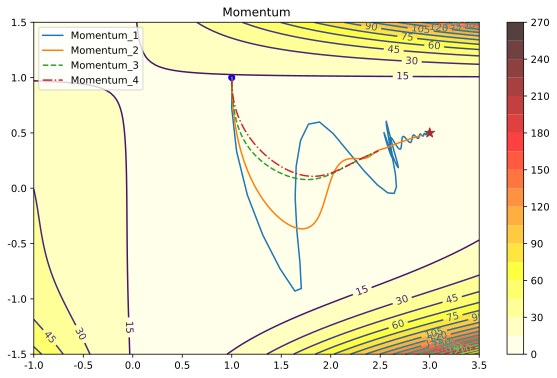

In [10]:
InteractiveShell.ast_node_interactivity = "last"
plt.figure(figsize=(10,6))

plt.title('Momentum')
x1_con = np.linspace(-1,3.5,100)
x2_con = np.linspace(-1.5,1.5,100)
x1_mes, x2_mes = np.meshgrid(x1_con,x2_con)
y_con = Beale(x1_mes,x2_mes)
# plt.plot(x1_mes, x2_mes)
cset = plt.contourf(x1_mes,x2_mes,y_con, levels=20, alpha=.75, cmap='hot_r')
plt.colorbar(cset)
C = plt.contour(x1_mes,x2_mes,y_con, levels=20, camp='RdYlBu')  
plt.clabel(C, inline=True, fontsize=10)
plt.scatter(1, 1, marker="8", color="b", s=40)
plt.scatter(3, 0.5, marker="*", color="brown", s=100)


Momentum_path_1 = Beale_Gradient_Descent(start, Momentum(eta=1e-1))
x_path, y_path = Momentum_path_1[:,0][0:100], Momentum_path_1[:,1][0:100]
plt.plot(x_path, y_path, label='Momentum_1')

Momentum_path_2 = Beale_Gradient_Descent(start, Momentum(eta=1e-2))
x_path, y_path = Momentum_path_2[:,0][0:500], Momentum_path_2[:,1][0:500]
plt.plot(x_path, y_path, label='Momentum_2', linestyle='-')

Momentum_path_3 = Beale_Gradient_Descent(start, Momentum(eta=1e-3))
x_path, y_path = Momentum_path_3[:,0][0:1000], Momentum_path_3[:,1][0:1000]
plt.plot(x_path, y_path, label='Momentum_3', linestyle='--')

Momentum_path_4 = Beale_Gradient_Descent(start, Momentum(eta=1e-4))
x_path, y_path = Momentum_path_4[:,0][0:10000], Momentum_path_4[:,1][0:10000]
plt.plot(x_path, y_path, label='Momentum_4', linestyle='-.')

plt.legend(loc='upper left')

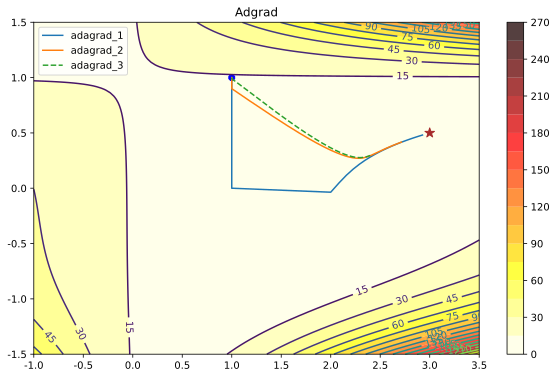

In [11]:
InteractiveShell.ast_node_interactivity = "last"
plt.figure(figsize=(10,6))

plt.title('Adgrad')
x1_con = np.linspace(-1,3.5,100)
x2_con = np.linspace(-1.5,1.5,100)
x1_mes, x2_mes = np.meshgrid(x1_con,x2_con)
y_con = Beale(x1_mes,x2_mes)
# plt.plot(x1_mes, x2_mes)
cset = plt.contourf(x1_mes,x2_mes,y_con, levels=20, alpha=.75, cmap='hot_r')
plt.colorbar(cset)
C = plt.contour(x1_mes,x2_mes,y_con, levels=20, camp='RdYlBu')  
plt.clabel(C, inline=True, fontsize=10)
plt.scatter(1, 1, marker="8", color="b", s=40)
plt.scatter(3, 0.5, marker="*", color="brown", s=100)


adagrad_path_1 = Beale_Gradient_Descent(start, Adagrad(eta=1))
x_path, y_path = adagrad_path_1[:,0][0:50], adagrad_path_1[:,1][0:50]
plt.plot(x_path, y_path, label='adagrad_1')

adagrad_path_2 = Beale_Gradient_Descent(start, Adagrad(eta=1e-1))
x_path, y_path = adagrad_path_2[:,0][0:500], adagrad_path_2[:,1][0:500]
plt.plot(x_path, y_path, label='adagrad_2', linestyle='-')

adagrad_path_3 = Beale_Gradient_Descent(start, Adagrad(eta=1e-2))
x_path, y_path = adagrad_path_3[:,0][0:10000], adagrad_path_3[:,1][0:10000]
plt.plot(x_path, y_path, label='adagrad_3', linestyle='--')


plt.legend(loc='upper left')

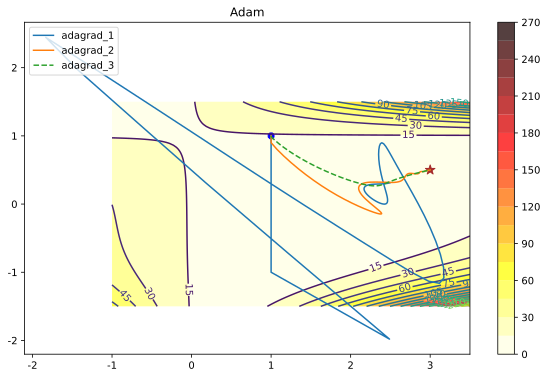

In [12]:
InteractiveShell.ast_node_interactivity = "last"
plt.figure(figsize=(10,6))

plt.title('Adam')
x1_con = np.linspace(-1,3.5,100)
x2_con = np.linspace(-1.5,1.5,100)
x1_mes, x2_mes = np.meshgrid(x1_con,x2_con)
y_con = Beale(x1_mes,x2_mes)
# plt.plot(x1_mes, x2_mes)
cset = plt.contourf(x1_mes,x2_mes,y_con, levels=20, alpha=.75, cmap='hot_r')
plt.colorbar(cset)
C = plt.contour(x1_mes,x2_mes,y_con, levels=20, camp='RdYlBu')  
plt.clabel(C, inline=True, fontsize=10)
plt.scatter(1, 1, marker="8", color="b", s=40)
plt.scatter(3, 0.5, marker="*", color="brown", s=100)


adam_path_1 = Beale_Gradient_Descent(start, Adam(eta=2))
x_path, y_path = adam_path_1[:,0][0:100], adam_path_1[:,1][0:100]
plt.plot(x_path, y_path, label='adagrad_1')

adam_path_2 = Beale_Gradient_Descent(start, Adam(eta=1e-1))
x_path, y_path = adam_path_2[:,0][0:500], adam_path_2[:,1][0:500]
plt.plot(x_path, y_path, label='adagrad_2', linestyle='-')

adam_path_3 = Beale_Gradient_Descent(start, Adam(eta=1e-2))
x_path, y_path = adam_path_3[:,0][0:10000], adam_path_3[:,1][0:10000]
plt.plot(x_path, y_path, label='adagrad_3', linestyle='--')


plt.legend(loc='upper left')

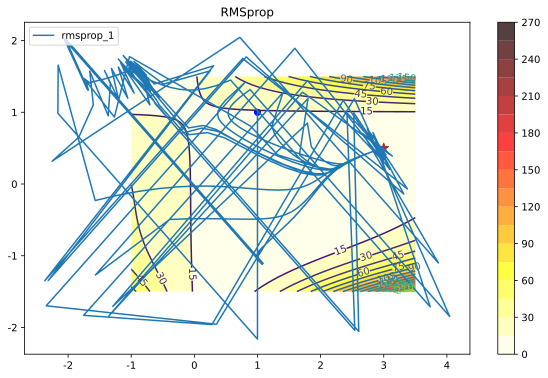

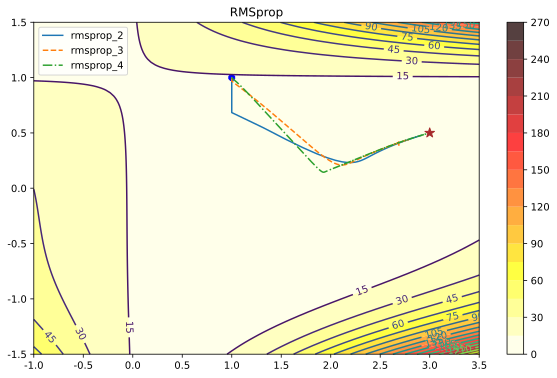

In [13]:
from IPython.core.interactiveshell import InteractiveShell


InteractiveShell.ast_node_interactivity = "last"
plt.figure(figsize=(10,6))

plt.title('RMSprop')
x1_con = np.linspace(-1,3.5,100)
x2_con = np.linspace(-1.5,1.5,100)
x1_mes, x2_mes = np.meshgrid(x1_con,x2_con)
y_con = Beale(x1_mes,x2_mes)
# plt.plot(x1_mes, x2_mes)
cset = plt.contourf(x1_mes,x2_mes,y_con, levels=20, alpha=.75, cmap='hot_r')
plt.colorbar(cset)
C = plt.contour(x1_mes,x2_mes,y_con, levels=20, camp='RdYlBu')  
plt.clabel(C, inline=True, fontsize=10)
plt.scatter(1, 1, marker="8", color="b", s=40)
plt.scatter(3, 0.5, marker="*", color="brown", s=100)


rms_path_1 = Beale_Gradient_Descent(start, RMSprop(eta=1))
x_path, y_path = rms_path_1[:,0][0:1000], rms_path_1[:,1][0:1000]
plt.plot(x_path, y_path, label='rmsprop_1')

# rms_path_2 = Beale_Gradient_Descent(start, RMSprop(eta=1e-1))
# x_path, y_path = rms_path_2[:,0][0:400], rms_path_2[:,1][0:400]
# plt.plot(x_path, y_path, label='rmsprop_2', linestyle='-')

# rms_path_3 = Beale_Gradient_Descent(start, RMSprop(eta=1e-2))
# x_path, y_path = rms_path_3[:,0][0:400], rms_path_3[:,1][0:400]
# plt.plot(x_path, y_path, label='rmsprop_3', linestyle='--')

# rms_path_4 = Beale_Gradient_Descent(start, RMSprop(eta=1e-3))
# x_path, y_path = rms_path_4[:,0][0:400], rms_path_4[:,1][0:400]
# plt.plot(x_path, y_path, label='rmsprop_4', linestyle='-.')

plt.legend(loc='upper left')


from IPython.core.interactiveshell import InteractiveShell


InteractiveShell.ast_node_interactivity = "last"
plt.figure(figsize=(10,6))

plt.title('RMSprop')
x1_con = np.linspace(-1,3.5,100)
x2_con = np.linspace(-1.5,1.5,100)
x1_mes, x2_mes = np.meshgrid(x1_con,x2_con)
y_con = Beale(x1_mes,x2_mes)
# plt.plot(x1_mes, x2_mes)
cset = plt.contourf(x1_mes,x2_mes,y_con, levels=20, alpha=.75, cmap='hot_r')
plt.colorbar(cset)
C = plt.contour(x1_mes,x2_mes,y_con, levels=20, camp='RdYlBu')  
plt.clabel(C, inline=True, fontsize=10)
plt.scatter(1, 1, marker="8", color="b", s=40)
plt.scatter(3, 0.5, marker="*", color="brown", s=100)


# rms_path_1 = Beale_Gradient_Descent(start, RMSprop(eta=1))
# x_path, y_path = rms_path_1[:,0][0:400], rms_path_1[:,1][0:400]
# plt.plot(x_path, y_path, label='rmsprop_1')

rms_path_2 = Beale_Gradient_Descent(start, RMSprop(eta=1e-1))
x_path, y_path = rms_path_2[:,0][0:50], rms_path_2[:,1][0:50]
plt.plot(x_path, y_path, label='rmsprop_2', linestyle='-')

rms_path_3 = Beale_Gradient_Descent(start, RMSprop(eta=1e-2))
x_path, y_path = rms_path_3[:,0][0:200], rms_path_3[:,1][0:200]
plt.plot(x_path, y_path, label='rmsprop_3', linestyle='--')

rms_path_4 = Beale_Gradient_Descent(start, RMSprop(eta=1e-3))
x_path, y_path = rms_path_4[:,0][0:2000], rms_path_4[:,1][0:2000]
plt.plot(x_path, y_path, label='rmsprop_4', linestyle='-.')

plt.legend(loc='upper left')

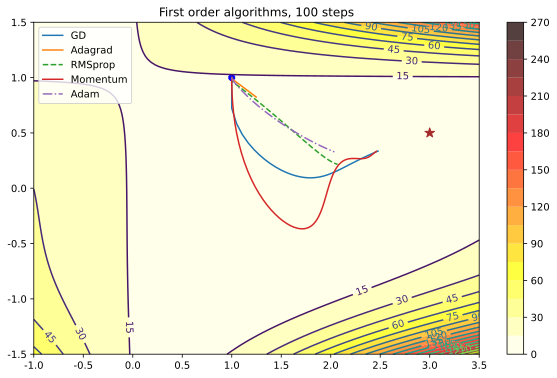

In [14]:
GD_path = Beale_Gradient_Descent(start, GD(eta=1e-2))
Adagrad_path = Beale_Gradient_Descent(start, Adagrad(eta=1e-2))
RMSprop_path = Beale_Gradient_Descent(start, RMSprop(eta=1e-2))
Momentum_path = Beale_Gradient_Descent(start, Momentum(eta=1e-2))
Adam_path = Beale_Gradient_Descent(start, Adam(eta=1e-2))


from IPython.core.interactiveshell import InteractiveShell


InteractiveShell.ast_node_interactivity = "last"
plt.figure(figsize=(10,6))




plt.title('First order algorithms, 100 steps')
x1_con = np.linspace(-1,3.5,100)
x2_con = np.linspace(-1.5,1.5,100)
x1_mes, x2_mes = np.meshgrid(x1_con,x2_con)
y_con = Beale(x1_mes,x2_mes)
# plt.plot(x1_mes, x2_mes)
cset = plt.contourf(x1_mes,x2_mes,y_con, levels=20, alpha=.75, cmap='hot_r')
plt.colorbar(cset)
C = plt.contour(x1_mes,x2_mes,y_con, levels=20, camp='RdYlBu')  
plt.clabel(C, inline=True, fontsize=10)


plt.scatter(1, 1, marker="8", color="b", s=40)
plt.scatter(3, 0.5, marker="*", color="brown", s=100)


N_step = 100

path = GD_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='GD')

path = Adagrad_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='Adagrad', linestyle='-')

path = RMSprop_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='RMSprop', linestyle='--')

path = Momentum_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='Momentum')

path = Adam_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='Adam', linestyle='-.')
# plt.xlim((-1,4))
# plt.ylim((-1,3))
plt.legend(loc='upper left')

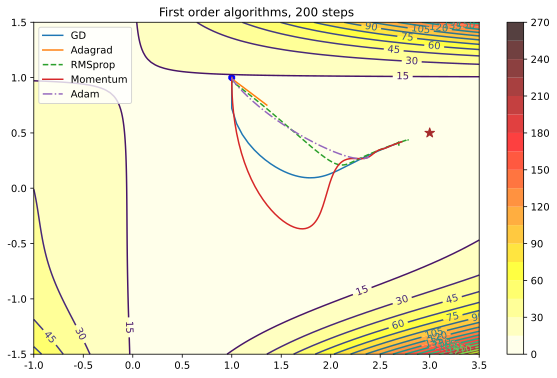

In [15]:

InteractiveShell.ast_node_interactivity = "last"
plt.figure(figsize=(10,6))




plt.title('First order algorithms, 200 steps')
x1_con = np.linspace(-1,3.5,100)
x2_con = np.linspace(-1.5,1.5,100)
x1_mes, x2_mes = np.meshgrid(x1_con,x2_con)
y_con = Beale(x1_mes,x2_mes)
# plt.plot(x1_mes, x2_mes)
cset = plt.contourf(x1_mes,x2_mes,y_con, levels=20, alpha=.75, cmap='hot_r')
plt.colorbar(cset)
C = plt.contour(x1_mes,x2_mes,y_con, levels=20, camp='RdYlBu')  
plt.clabel(C, inline=True, fontsize=10)


plt.scatter(1, 1, marker="8", color="b", s=40)
plt.scatter(3, 0.5, marker="*", color="brown", s=100)

N_step = 200

path = GD_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='GD')

path = Adagrad_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='Adagrad', linestyle='-')

path = RMSprop_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='RMSprop', linestyle='--')

path = Momentum_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='Momentum')

path = Adam_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='Adam', linestyle='-.')
# plt.xlim((-1,4))
# plt.ylim((-1,3))
plt.legend(loc='upper left')

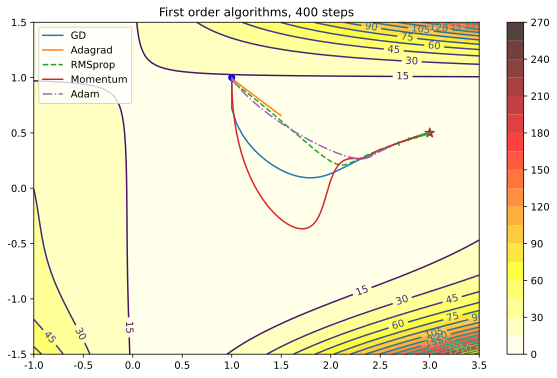

In [16]:

InteractiveShell.ast_node_interactivity = "last"
plt.figure(figsize=(10,6))




plt.title('First order algorithms, 400 steps')
x1_con = np.linspace(-1,3.5,100)
x2_con = np.linspace(-1.5,1.5,100)
x1_mes, x2_mes = np.meshgrid(x1_con,x2_con)
y_con = Beale(x1_mes,x2_mes)
# plt.plot(x1_mes, x2_mes)
cset = plt.contourf(x1_mes,x2_mes,y_con, levels=20, alpha=.75, cmap='hot_r')
plt.colorbar(cset)
C = plt.contour(x1_mes,x2_mes,y_con, levels=20, camp='RdYlBu')  
plt.clabel(C, inline=True, fontsize=10)


plt.scatter(1, 1, marker="8", color="b", s=40)
plt.scatter(3, 0.5, marker="*", color="brown", s=100)

N_step = 400

path = GD_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='GD')

path = Adagrad_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='Adagrad', linestyle='-')

path = RMSprop_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='RMSprop', linestyle='--')

path = Momentum_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='Momentum')

path = Adam_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='Adam', linestyle='-.')
# plt.xlim((-1,4))
# plt.ylim((-1,3))
plt.legend(loc='upper left')

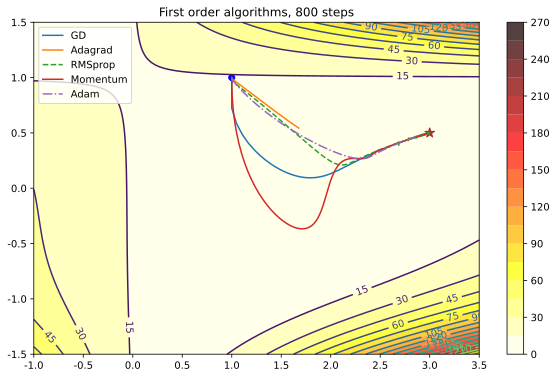

In [17]:

InteractiveShell.ast_node_interactivity = "last"
plt.figure(figsize=(10,6))




plt.title('First order algorithms, 800 steps')
x1_con = np.linspace(-1,3.5,100)
x2_con = np.linspace(-1.5,1.5,100)
x1_mes, x2_mes = np.meshgrid(x1_con,x2_con)
y_con = Beale(x1_mes,x2_mes)
# plt.plot(x1_mes, x2_mes)
cset = plt.contourf(x1_mes,x2_mes,y_con, levels=20, alpha=.75, cmap='hot_r')
plt.colorbar(cset)
C = plt.contour(x1_mes,x2_mes,y_con, levels=20, camp='RdYlBu')  
plt.clabel(C, inline=True, fontsize=10)


plt.scatter(1, 1, marker="8", color="b", s=40)
plt.scatter(3, 0.5, marker="*", color="brown", s=100)

N_step = 800

path = GD_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='GD')

path = Adagrad_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='Adagrad', linestyle='-')

path = RMSprop_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='RMSprop', linestyle='--')

path = Momentum_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='Momentum')

path = Adam_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='Adam', linestyle='-.')
# plt.xlim((-1,4))
# plt.ylim((-1,3))
plt.legend(loc='upper left')

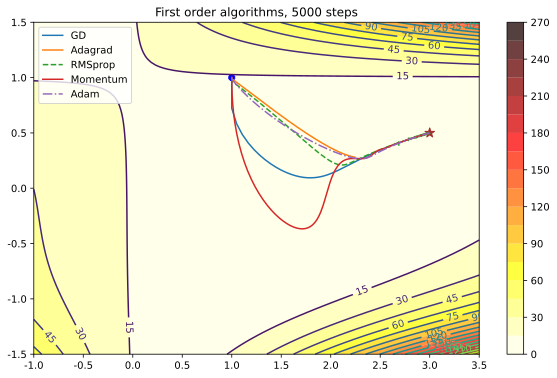

In [18]:

InteractiveShell.ast_node_interactivity = "last"
plt.figure(figsize=(10,6))




plt.title('First order algorithms, 5000 steps')
x1_con = np.linspace(-1,3.5,100)
x2_con = np.linspace(-1.5,1.5,100)
x1_mes, x2_mes = np.meshgrid(x1_con,x2_con)
y_con = Beale(x1_mes,x2_mes)
# plt.plot(x1_mes, x2_mes)
cset = plt.contourf(x1_mes,x2_mes,y_con, levels=20, alpha=.75, cmap='hot_r')
plt.colorbar(cset)
C = plt.contour(x1_mes,x2_mes,y_con, levels=20, camp='RdYlBu')  
plt.clabel(C, inline=True, fontsize=10)


plt.scatter(1, 1, marker="8", color="b", s=40)
plt.scatter(3, 0.5, marker="*", color="brown", s=100)

N_step = 5000

path = GD_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='GD')

path = Adagrad_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='Adagrad', linestyle='-')

path = RMSprop_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='RMSprop', linestyle='--')

path = Momentum_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='Momentum')

path = Adam_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='Adam', linestyle='-.')
# plt.xlim((-1,4))
# plt.ylim((-1,3))
plt.legend(loc='upper left')

#### Change the stepsize of adagrad to 1

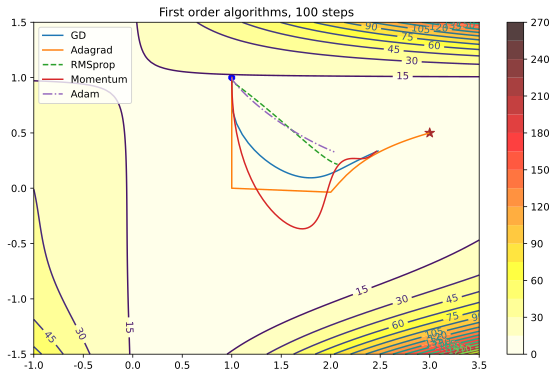

In [19]:
 
Adagrad_path = Beale_Gradient_Descent(start, Adagrad(eta=1))
 


from IPython.core.interactiveshell import InteractiveShell


InteractiveShell.ast_node_interactivity = "last"
plt.figure(figsize=(10,6))




plt.title('First order algorithms, 100 steps')
x1_con = np.linspace(-1,3.5,100)
x2_con = np.linspace(-1.5,1.5,100)
x1_mes, x2_mes = np.meshgrid(x1_con,x2_con)
y_con = Beale(x1_mes,x2_mes)
# plt.plot(x1_mes, x2_mes)
cset = plt.contourf(x1_mes,x2_mes,y_con, levels=20, alpha=.75, cmap='hot_r')
plt.colorbar(cset)
C = plt.contour(x1_mes,x2_mes,y_con, levels=20, camp='RdYlBu')  
plt.clabel(C, inline=True, fontsize=10)


plt.scatter(1, 1, marker="8", color="b", s=40)
plt.scatter(3, 0.5, marker="*", color="brown", s=100)


N_step = 100

path = GD_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='GD')

path = Adagrad_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='Adagrad', linestyle='-')

path = RMSprop_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='RMSprop', linestyle='--')

path = Momentum_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='Momentum')

path = Adam_path
x_path, y_path = path[:,0][:N_step], path[:,1][:N_step]
plt.plot(x_path, y_path, label='Adam', linestyle='-.')
# plt.xlim((-1,4))
# plt.ylim((-1,3))
plt.legend(loc='upper left')